In [9]:
import numpy as np
import pandas as pd
 
from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
 
import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

In [10]:
# Ignore all warnings
warnings.filterwarnings('ignore')

In [11]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "s_1",
"s_2",
"s_3",
"s_4",
"s_5",
"s_6",
"s_7",
"s_8",
"s_9",
"s_10",
"s_11",
"s_12",
"s_13",
"s_14",
"s_15",
"s_16",
"s_17",
"s_18",
"s_19",
"s_20",
"s_21" ]
col_names = index_names + setting_names + sensor_names
 
df_train = pd.read_csv(('train_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])


In [12]:
sens_const_values = []
for feature in list(setting_names + sensor_names):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass
 
print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)
 
['setting_3', '(Fan inlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(Engine pressure ratio(P50/P2)', '(Burner fuel-air ratio)', '(Required fan speed)', '(Required fan conversion speed)']


['setting_3', 's_1', 's_5', 's_10', 's_16', 's_18', 's_19']


['setting_3',
 '(Fan inlet temperature) (◦R)',
 '(Fan inlet Pressure) (psia)',
 '(Engine pressure ratio(P50/P2)',
 '(Burner fuel-air ratio)',
 '(Required fan speed)',
 '(Required fan conversion speed)']

In [5]:
features = list(df_train.columns)
list(df_train)
 
['engine',
 'cycle',
 'setting_1',
 'setting_2',
 '(LPC outlet temperature) (◦R)',
 '(HPC outlet temperature) (◦R)',
 '(LPT outlet temperature) (◦R)',
 '(bypass-duct pressure) (psia)',
 '(HPC outlet pressure) (psia)',
 '(Physical fan speed) (rpm)',
 '(Physical core speed) (rpm)',
 '(HPC outlet Static pressure) (psia)',
 '(Ratio of fuel flow to Ps30) (pps/psia)',
 '(Corrected fan speed) (rpm)',
 '(Bypass Ratio) ',
 '(Bleed Enthalpy)',
 '(High-pressure turbines Cool air flow)',
 '(Low-pressure turbines Cool air flow)']


['engine',
 'cycle',
 'setting_1',
 'setting_2',
 '(LPC outlet temperature) (◦R)',
 '(HPC outlet temperature) (◦R)',
 '(LPT outlet temperature) (◦R)',
 '(bypass-duct pressure) (psia)',
 '(HPC outlet pressure) (psia)',
 '(Physical fan speed) (rpm)',
 '(Physical core speed) (rpm)',
 '(HPC outlet Static pressure) (psia)',
 '(Ratio of fuel flow to Ps30) (pps/psia)',
 '(Corrected fan speed) (rpm)',
 '(Bypass Ratio) ',
 '(Bleed Enthalpy)',
 '(High-pressure turbines Cool air flow)',
 '(Low-pressure turbines Cool air flow)']

In [13]:
# define the maximum life of each engine, as this could be used to obtain the RUL at each point in time of the engine's life 
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.head()

,life
engine,
1,192
2,287
3,179
4,189
5,269


In [14]:
df_train=df_train.merge(df_train_RUL,how='left',on=['engine'])
 
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)
 
# the RUL prediction is only useful nearer to the end of the engine's life, therefore we put an upper limit on the RUL
# this is a bit sneaky, since it supposes that the test set has RULs of less than this value, the closer you are
# to the true value, the more accurate the model will be
df_train['RUL'][df_train['RUL']>125]=125
#df_train.head()

In [15]:
selected_features=df_train[['cycle', 's_2','s_3','s_4','s_7','s_8',
                    's_11','s_12','s_13','s_15','s_17','s_20','s_21']]
feature_names=selected_features


In [16]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the DataFrame to store model performance metrics
model_performance = pd.DataFrame(columns=['R2', 'RMSE', 'time to train', 'time to predict', 'total time'])

def R_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


In [10]:
df_train.columns

Index(['engine', 'cycle', 'setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_6',
       's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17',
       's_20', 's_21', 'RUL'],
      dtype='object')

In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# Step 1: Grouping test data by 'engine' to get the maximum cycle for each engine
df_test_cycle = df_test.groupby(['engine']).agg({'cycle': 'max'})
df_test_cycle.rename(columns={'cycle': 'life'}, inplace=True)

# Step 2: Merging to get the life of each engine
df_test_max = df_test.merge(df_test_cycle, how='left', on=['engine'])

# Step 3: Verify column names and types before filtering
print("Columns in df_test_max:")
print(df_test_max.columns)
print("Data types of 'cycle' and 'life':")
print(df_test_max[['cycle', 'life']].dtypes)

# Step 4: Ensure the types are compatible for comparison
df_test_max['cycle'] = df_test_max['cycle'].astype(int)
df_test_max['life'] = df_test_max['life'].astype(int)

# Step 5: Filter rows where cycle equals life
df_test_max = df_test_max[df_test_max['cycle'] == df_test_max['life']]

# Step 6: Drop the 'life' column
df_test_max.drop(['life'], axis=1, inplace=True)

# Step 7: Prepare training datasets
X = df_train[['cycle', 's_2','s_3','s_4','s_7','s_8',
               's_11','s_12','s_13','s_15','s_17','s_20','s_21']]
y = df_train['RUL']

# Step 8: Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Prepare the test dataset
X_test = df_test_max[['cycle', 's_2','s_3','s_4','s_7','s_8',
                       's_11','s_12','s_13','s_15','s_17','s_20','s_21']]
y_test = df_test_RUL['RUL']

# Step 10: Check if X_test and y_test have the same number of samples
assert len(X_test) == len(y_test), "The number of samples in X_test and y_test must match."

# Step 11: Scale the features
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Step 12: Model Training (Using KNN as an example)
model = KNeighborsRegressor(n_neighbors=9)
model.fit(X_train, y_train)

# Step 13: Make Predictions on Validation Set
y_val_predictions = model.predict(X_val)

# Step 14: Evaluate Model Performance on Validation Set
val_mse = mean_squared_error(y_val, y_val_predictions)
val_r2 = r2_score(y_val, y_val_predictions)

# Step 15: Print Validation Performance Metrics
print('Validation Mean Squared Error:', val_mse)
print('Validation R-squared:', val_r2)

# Step 16: Make Predictions on Test Set
y_test_predictions = model.predict(X_test)

# Step 17: Evaluate Model Performance on Test Set
test_mse = mean_squared_error(y_test, y_test_predictions)
test_r2 = r2_score(y_test, y_test_predictions)

# Step 18: Print Test Performance Metrics
print('Test Mean Squared Error:', test_mse)
print('Test R-squared:', test_r2)


Columns in df_test_max:
Index(['engine', 'cycle', 'setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_6',
       's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17',
       's_20', 's_21', 'life'],
      dtype='object')
Data types of 'cycle' and 'life':
cycle    int64
life     int64
dtype: object
Validation Mean Squared Error: 320.5530636847978
Validation R-squared: 0.8110544285333938
Test Mean Squared Error: 409.2624691358024
Test R-squared: 0.7630032579554342


In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Grouping test data by 'engine' to get the maximum cycle for each engine
df_test_cycle = df_test.groupby(['engine']).agg({'cycle': 'max'})
df_test_cycle.rename(columns={'cycle': 'life'}, inplace=True)

# Step 2: Merging to get the life of each engine
df_test_max = df_test.merge(df_test_cycle, how='left', on=['engine'])

# Step 3: Verify column names and types before filtering
print("Columns in df_test_max:")
print(df_test_max.columns)
print("Data types of 'cycle' and 'life':")
print(df_test_max[['cycle', 'life']].dtypes)

# Step 4: Ensure the types are compatible for comparison
df_test_max['cycle'] = df_test_max['cycle'].astype(int)
df_test_max['life'] = df_test_max['life'].astype(int)

# Step 5: Filter rows where cycle equals life
df_test_max = df_test_max[df_test_max['cycle'] == df_test_max['life']]

# Step 6: Drop the 'life' column
df_test_max.drop(['life'], axis=1, inplace=True)

# Step 7: Prepare training and testing datasets
X_train = df_train[['cycle', 's_2','s_3','s_4','s_7','s_8',
                    's_11','s_12','s_13','s_15','s_17','s_20','s_21']]
y_train = df_train['RUL']
X_test = df_test_max[['cycle', 's_2','s_3','s_4','s_7','s_8',
                    's_11','s_12','s_13','s_15','s_17','s_20','s_21']]
y_test = df_test_RUL['RUL']

# Step 8: Check if X_test and y_test have the same number of samples
assert len(X_test) == len(y_test), "The number of samples in X_test and y_test must match."

# Step 9: Scale the features
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Step 10: Model Training (Using KNN as an example)
from sklearn.neighbors import KNeighborsRegressor

# Fit the model
model = KNeighborsRegressor(n_neighbors=9)
model.fit(X_train, y_train)

# Step 11: Make Predictions
y_predictions = model.predict(X_test)

# Step 12: Evaluate Model Performance
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

# Step 13: Print Model Performance Metrics
print('Mean Squared Error:', mse)
print('R-squared:', r2)


Columns in df_test_max:
Index(['engine', 'cycle', 'setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_6',
       's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17',
       's_20', 's_21', 'life'],
      dtype='object')
Data types of 'cycle' and 'life':
cycle    int64
life     int64
dtype: object
Mean Squared Error: 404.68283950617274
R-squared: 0.7656552414228771


In [17]:
# Grouping test data by 'engine' to get the maximum cycle for each engine
df_test_cycle = df_test.groupby(['engine']).agg({'cycle': 'max'})
df_test_cycle.rename(columns={'cycle': 'life'}, inplace=True)

# Merging to get the life of each engine
df_test_max = df_test.merge(df_test_cycle, how='left', on=['engine'])

# Verify column names and types before filtering
print(df_test_max.columns)
print(df_test_max[['cycle', 'life']].dtypes)

# Ensure the types are compatible for comparison
df_test_max['cycle'] = df_test_max['cycle'].astype(int)
df_test_max['life'] = df_test_max['life'].astype(int)

# Filter rows where cycle equals life
df_test_max = df_test_max[df_test_max['cycle'] == df_test_max['life']]

# Drop the 'life' column
df_test_max.drop(['life'], axis=1, inplace=True)

# Prepare training and testing datasets
X_train = df_train[['cycle', 's_2','s_3','s_4','s_7','s_8',
                    's_11','s_12','s_13','s_15','s_17','s_20','s_21']]
y_train = df_train['RUL']
X_test = df_test_max[['cycle', 's_2','s_3','s_4','s_7','s_8',
                    's_11','s_12','s_13','s_15','s_17','s_20','s_21']]
y_test = df_test_RUL['RUL']
# Scale the features
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Index(['engine', 'cycle', 'setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_6',
       's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17',
       's_20', 's_21', 'life'],
      dtype='object')
cycle    int64
life     int64
dtype: object


In [18]:
import time

In [19]:
%%time
from sklearn.neighbors import KNeighborsRegressor
start = time.time()
model = KNeighborsRegressor(n_neighbors=9).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()
 
 
 
model_performance.loc['kNN'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]
 
print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
 


R-squared error: 76.57%
Root Mean Squared Error: 20.12
CPU times: total: 219 ms
Wall time: 289 ms


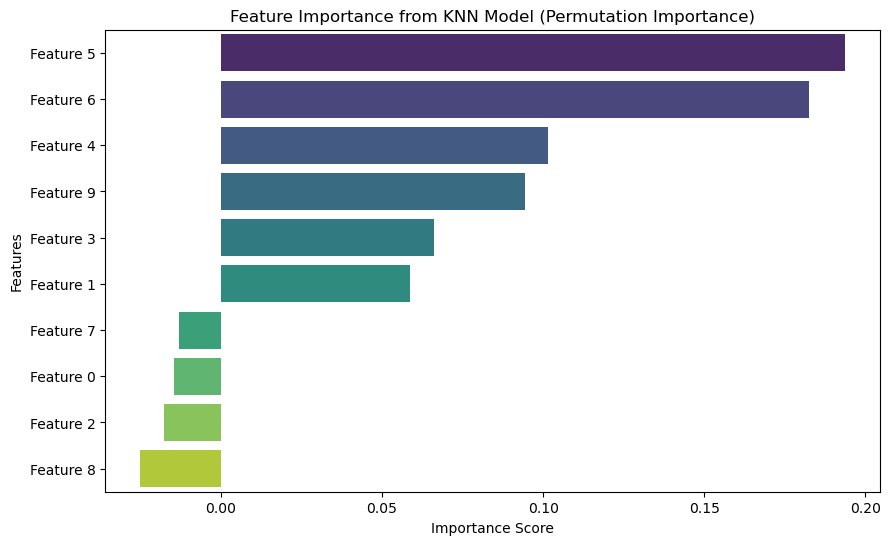

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Sample data
# df = pd.read_csv('your_dataset.csv')  # Load your dataset
# Assuming df has your features and target variable
# X = df.drop('target_variable', axis=1)
# y = df['target_variable']

# For demonstration, let's create a synthetic dataset
X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the KNN model
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Step 3: Calculate permutation importance
# Ensure y_test is 1-dimensional
y_test_1d = y_test.ravel() if y_test.ndim > 1 else y_test

# Calculate permutation importance
result = permutation_importance(model, X_test, y_test_1d, n_repeats=30, random_state=42)

# Step 4: Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
})

# Step 5: Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 6: Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from KNN Model (Permutation Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


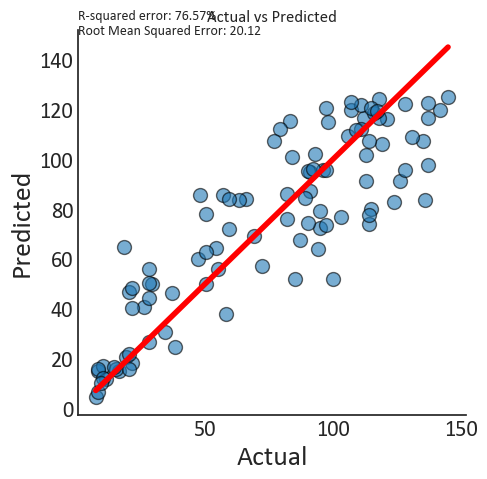

In [13]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=5,5
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['legend.fontsize']=16
 
fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='red',
             ax=ax)
 
plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')
 
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

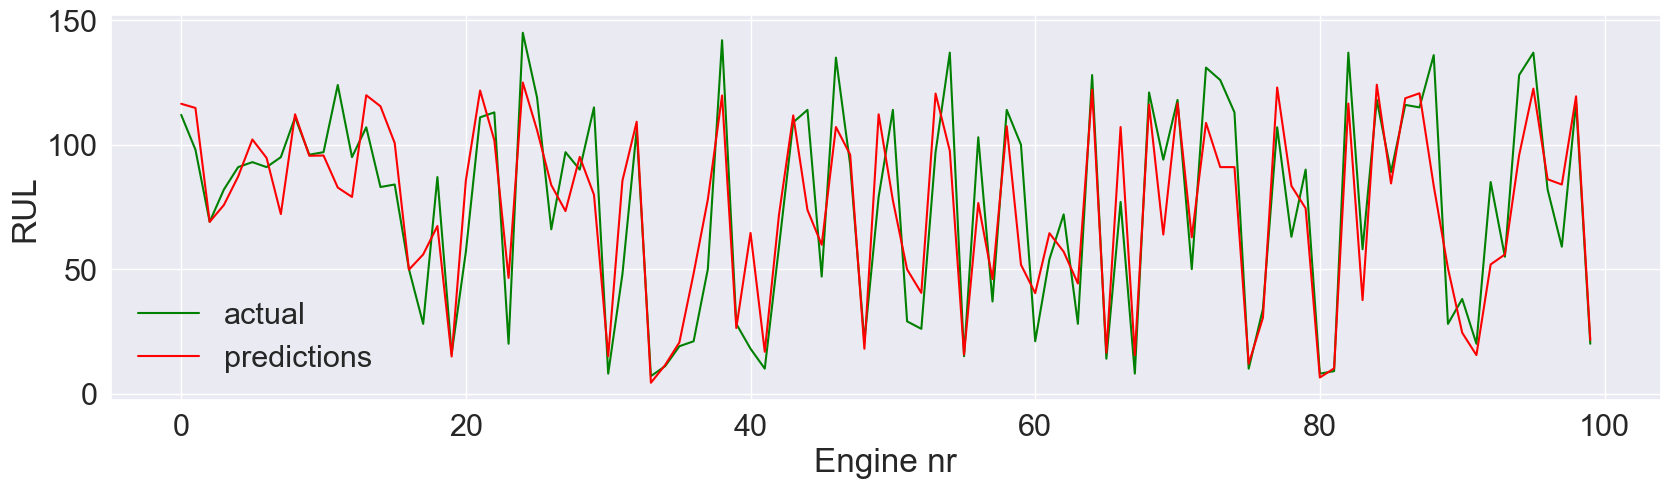

In [14]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=20,5
sns.set(font_scale=2)
 
fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')
 
g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='green',
                label = 'actual',
                ax=ax)
 
f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='red',
                label = 'predictions',
                ax=ax)
ax.legend()


In [29]:
#validation testing 
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# Step 1: Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 2: Fit the SVR model
start = time.time()
model = SVR(kernel="rbf", C=100, gamma=0.5, epsilon=0.01).fit(X_train_split, y_train_split)
end_train = time.time()

# Step 3: Make predictions on the test data
y_predictions = model.predict(X_test)  # Predictions on the test data
end_predict = time.time()

# Step 4: Calculate performance metrics for the test data
model_performance.loc['SVM'] = [
    model.score(X_test, y_test),  # R-squared on test data
    mean_squared_error(y_test, y_predictions, squared=False),  # RMSE on test data
    end_train - start,  # Time to train
    end_predict - end_train,  # Time to predict
    end_predict - start  # Total time
]

# Step 5: Validate the model using the validation set
y_val_predictions = model.predict(X_val)  # Predictions on validation data

# Step 6: Calculate performance metrics for the validation data
validation_mse = mean_squared_error(y_val, y_val_predictions, squared=False)  # RMSE for validation
validation_r2 = model.score(X_val, y_val)  # R-squared for validation

# Step 7: Add validation metrics to model performance
model_performance.loc['SVM Validation'] = [
    validation_r2,
    validation_mse,
    None,  # Time to train is not applicable for validation
    None,  # Time to predict is not applicable for validation
    None   # Total time is not applicable for validation
]

# Step 8: Print the results
print('R-squared error (Test): ' + "{:.2%}".format(model.score(X_test, y_test)))
print('Root Mean Squared Error (Test): ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions, squared=False)))
print('R-squared error (Validation): ' + "{:.2%}".format(validation_r2))
print('Root Mean Squared Error (Validation): ' + "{:.2f}".format(validation_mse))


R-squared error (Test): 73.45%
Root Mean Squared Error (Test): 21.41
R-squared error (Validation): 81.00%
Root Mean Squared Error (Validation): 17.91


In [15]:
%%time
from sklearn.svm import SVR
start = time.time()
model = SVR(kernel="rbf", C=100, gamma=0.5, epsilon=0.01).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()
 
model_performance.loc['SVM'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]
 
print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
 


R-squared error: 73.81%
Root Mean Squared Error: 21.27
CPU times: total: 24.8 s
Wall time: 32.3 s


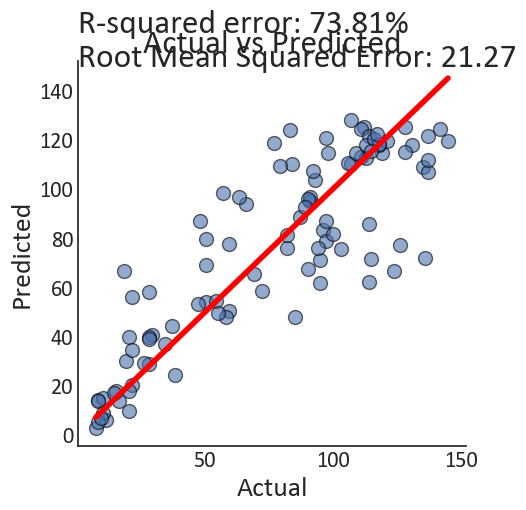

In [16]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=5,5
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['legend.fontsize']=16
 
fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='red',
             ax=ax)
 
plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')
 
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

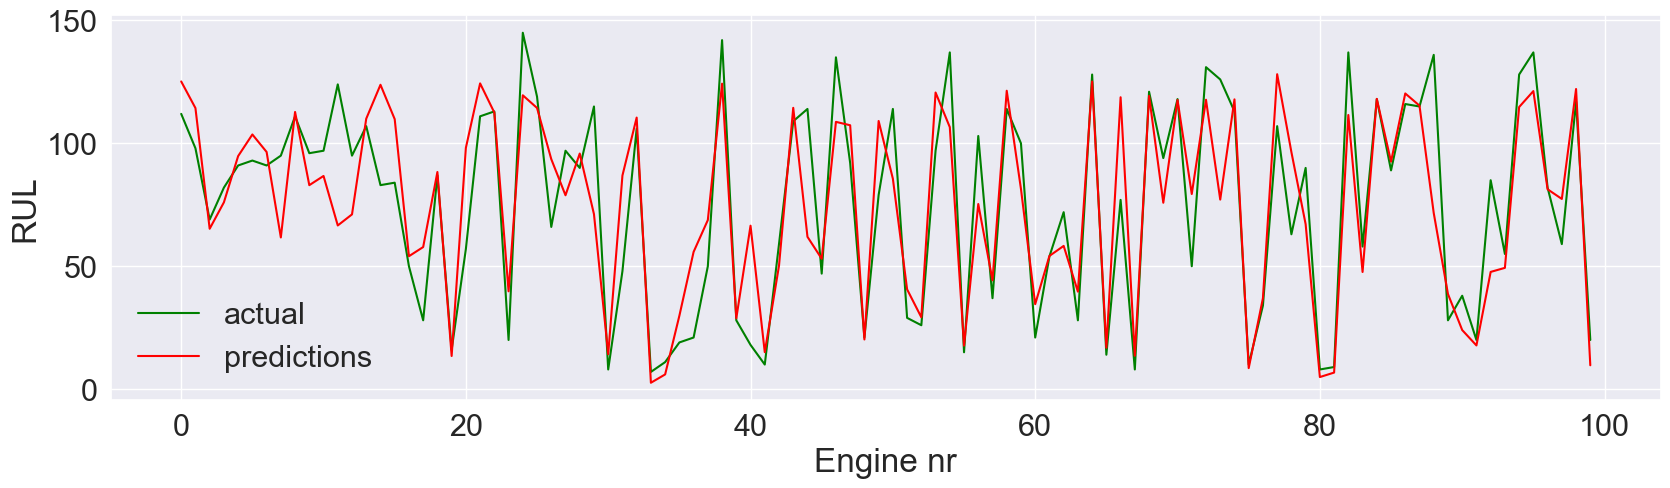

In [17]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=20,5
sns.set(font_scale=2)
 
fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')
 
g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='green',
                label = 'actual',
                ax=ax)
 
f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='red',
                label = 'predictions',
                ax=ax)
ax.legend()

In [30]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Step 1: Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 2: Fit the Random Forest model
start = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=500,
                              min_samples_leaf=1,
                              max_features='sqrt').fit(X_train_split, y_train_split)
end_train = time.time()

# Step 3: Make predictions on the test data
y_predictions = model.predict(X_test)  # Predictions on the test data
end_predict = time.time()

# Step 4: Calculate performance metrics for the test data
model_performance.loc['Random Forest'] = [
    model.score(X_test, y_test),  # R-squared on test data
    mean_squared_error(y_test, y_predictions, squared=False),  # RMSE on test data
    end_train - start,  # Time to train
    end_predict - end_train,  # Time to predict
    end_predict - start  # Total time
]

# Step 5: Validate the model using the validation set
y_val_predictions = model.predict(X_val)  # Predictions on validation data

# Step 6: Calculate performance metrics for the validation data
validation_mse = mean_squared_error(y_val, y_val_predictions, squared=False)  # RMSE for validation
validation_r2 = model.score(X_val, y_val)  # R-squared for validation

# Step 7: Add validation metrics to model performance
model_performance.loc['Random Forest Validation'] = [
    validation_r2,
    validation_mse,
    None,  # Time to train is not applicable for validation
    None,  # Time to predict is not applicable for validation
    None   # Total time is not applicable for validation
]

# Step 8: Print the results
print('R-squared error (Test): ' + "{:.2%}".format(model.score(X_test, y_test)))
print('Root Mean Squared Error (Test): ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions, squared=False)))
print('R-squared error (Validation): ' + "{:.2%}".format(validation_r2))
print('Root Mean Squared Error (Validation): ' + "{:.2f}".format(validation_mse))


R-squared error (Test): 76.26%
Root Mean Squared Error (Test): 20.25
R-squared error (Validation): 82.19%
Root Mean Squared Error (Validation): 17.34
CPU times: total: 31 s
Wall time: 5.62 s


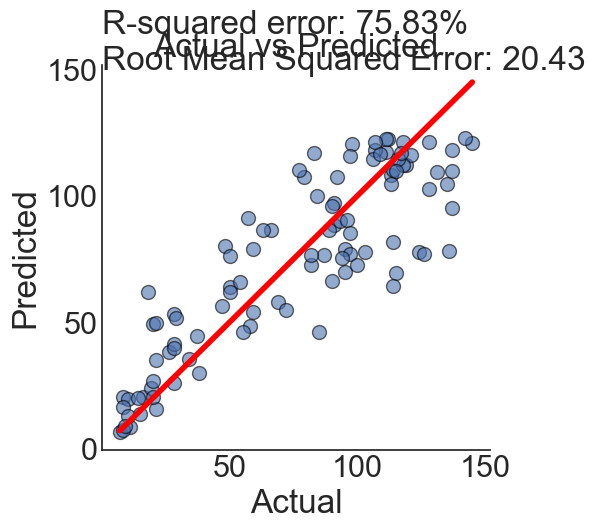

In [19]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=5,5
 
fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='red',
             ax=ax)
 
plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')
 
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

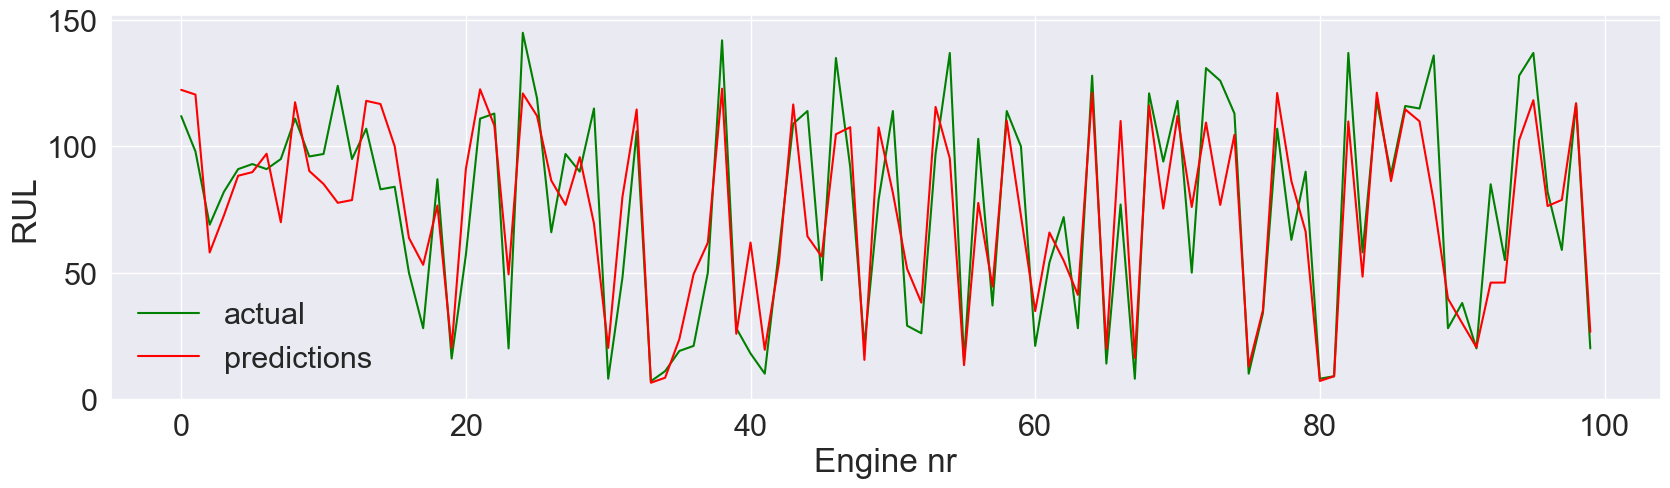

In [20]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=20,5
sns.set(font_scale=2)
fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')
 
g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='green',
                label = 'actual',
                ax=ax)
 
f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='red',
                label = 'predictions',
                ax=ax)
ax.legend()

In [21]:
%%time
from sklearn.tree import DecisionTreeRegressor

# Start timing the training process
start = time.time()

# Initialize and train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)  # You can set parameters as needed
dt_model.fit(X_train, y_train)

# End the training time
end_train = time.time()

# Make predictions on the test set
y_predictions_dt = dt_model.predict(X_test) 

# End the prediction time
end_predict = time.time()

# Store the model performance metrics
model_performance.loc['Decision Tree'] = [
    dt_model.score(X_test, y_test),  # R-squared score
    mean_squared_error(y_test, y_predictions_dt, squared=False),  # RMSE
    end_train - start,  # Time to train
    end_predict - end_train,  # Time to predict
    end_predict - start  # Total time
]

# Print the evaluation metrics
print('Decision Tree R-squared error: ' + "{:.2%}".format(dt_model.score(X_test, y_test)))
print('Decision Tree Root Mean Squared Error: ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions_dt, squared=False)))


Decision Tree R-squared error: 49.63%
Decision Tree Root Mean Squared Error: 29.49
CPU times: total: 250 ms
Wall time: 305 ms


In [26]:
%%time
from sklearn.linear_model import LinearRegression

# Start the timer for model training
start = time.time()

# Create and fit the Linear Regression model
model = LinearRegression().fit(X_train, y_train)

# Record the end time for training
end_train = time.time()

# Make predictions on the test data
y_predictions = model.predict(X_test)

# Record the end time for prediction
end_predict = time.time()

# Store the performance metrics in the DataFrame
model_performance.loc['Linear Regression'] = [
    model.score(X_test, y_test), 
    mean_squared_error(y_test, y_predictions, squared=False),
    end_train - start,
    end_predict - end_train,
    end_predict - start
]

# Print the evaluation metrics
print('R-squared error: ' + "{:.2%}".format(model.score(X_test, y_test)))
print('Root Mean Squared Error: ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions, squared=False)))


Columns in df_test_max:
Index(['engine', 'cycle', 'setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_6',
       's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17',
       's_20', 's_21', 'life'],
      dtype='object')
Data types of 'cycle' and 'life':
cycle    int64
life     int64
dtype: object
Validation Mean Squared Error: 320.5530636847978
Validation R-squared: 0.8110544285333938
Test Mean Squared Error: 409.2624691358024
Test R-squared: 0.7630032579554342


In [31]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Step 1: Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Start timing the training process
start = time.time()

# Initialize and train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)  # You can set parameters as needed
dt_model.fit(X_train_split, y_train_split)

# End the training time
end_train = time.time()

# Make predictions on the test set
y_predictions_dt = dt_model.predict(X_test) 

# End the prediction time
end_predict = time.time()

# Store the model performance metrics for the test data
model_performance.loc['Decision Tree'] = [
    dt_model.score(X_test, y_test),  # R-squared score on test data
    mean_squared_error(y_test, y_predictions_dt, squared=False),  # RMSE on test data
    end_train - start,  # Time to train
    end_predict - end_train,  # Time to predict
    end_predict - start  # Total time
]

# Step 5: Validate the model using the validation set
y_val_predictions_dt = dt_model.predict(X_val)  # Predictions on validation data

# Step 6: Calculate performance metrics for the validation data
validation_mse_dt = mean_squared_error(y_val, y_val_predictions_dt, squared=False)  # RMSE for validation
validation_r2_dt = dt_model.score(X_val, y_val)  # R-squared for validation

# Step 7: Add validation metrics to model performance
model_performance.loc['Decision Tree Validation'] = [
    validation_r2_dt,
    validation_mse_dt,
    None,  # Time to train is not applicable for validation
    None,  # Time to predict is not applicable for validation
    None   # Total time is not applicable for validation
]

# Step 8: Print the results
print('Decision Tree R-squared error (Test): ' + "{:.2%}".format(dt_model.score(X_test, y_test)))
print('Decision Tree Root Mean Squared Error (Test): ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions_dt, squared=False)))
print('Decision Tree R-squared error (Validation): ' + "{:.2%}".format(validation_r2_dt))
print('Decision Tree Root Mean Squared Error (Validation): ' + "{:.2f}".format(validation_mse_dt))


Decision Tree R-squared error (Test): 44.31%
Decision Tree Root Mean Squared Error (Test): 31.01
Decision Tree R-squared error (Validation): 62.44%
Decision Tree Root Mean Squared Error (Validation): 25.19
CPU times: total: 156 ms
Wall time: 187 ms


In [2]:
from sklearn.inspection import permutation_importance
